In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pickle
from mpl_toolkits import mplot3d
# import warnings
# warnings.filterwarnings("ignore")

# Reading Data

In [9]:
df_chunk = pd.read_csv('train.csv', chunksize = 500000, low_memory = False)
chunks = []

In [3]:
invalid = [0]*500000
coord_list = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount']
def mark_invalid(chunk):
    for c in coord_list:
        for i in chunk.index:
            if(c == "pickup_longitude" or c == "dropoff_longitude"):
                if(chunk[c][i].astype(float) > -73.699215 or chunk[c][i].astype(float) < -74.257159):
#                     chunk = chunk.replace(chunk[c][i],np.nan)
#                     chunk = chunk.drop([i])
                    invalid[i%500000] = 1
            elif (c == "pickup_latitude" or c == "dropoff_latitude"):
                if(chunk[c][i].astype(float) > 40.915568 or chunk[c][i].astype(float) < 40.495992):
#                     chunk = chunk.replace(chunk[c][i],np.nan)
#                     chunk = chunk.drop([i])
                    invalid[i%500000] = 1
            elif(c == "fare_amount"):
                if(chunk[c][i] >= 200 or chunk[c][i] <= 0):
#                     chunk = chunk.drop([i])
                    invalid[i%500000] = 1
    return chunk

invalid_test = [0]*1000000
coord_list_test = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
def mark_invalid_test(chunk):
    for c in coord_list_test:
        for i in chunk.index:
            if(c == "pickup_longitude" or c == "dropoff_longitude"):
                if(chunk[c][i].astype(float) > -73.699215 or chunk[c][i].astype(float) < -74.257159):
#                     chunk = chunk.replace(chunk[c][i],np.nan)
#                     chunk = chunk.drop([i])
                    invalid_test[i%1000000] = 1
            elif (c == "pickup_latitude" or c == "dropoff_latitude"):
                if(chunk[c][i].astype(float) > 40.915568 or chunk[c][i].astype(float) < 40.495992):
#                     chunk = chunk.replace(chunk[c][i],np.nan)
#                     chunk = chunk.drop([i])
                    invalid_test[i%1000000] = 1
    return chunk
        

In [4]:
def mark_outlier(chunk, data_1):
    outliers_indices=[]
    threshold = 3
    mean_1 = np.mean(data_1)
    std_1 = np.std(data_1)
    
#     length = len(data_1)
    for i in chunk.index:
        z_score= (data_1[i] - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers_indices.append(i)
    for i in outliers_indices:
#         chunk = chunk.drop([i])
        chunk['invalid'][i] = 1
    return chunk


# print(len(detect_outlier(chunks[1]['fare_amount'])))

In [12]:
def split_datetime(chunk):
    hours = []
    mins = []
    secs = []
    years = []
    months = []
    days = []
    length = len(chunk['pickup_longitude'])
    
    for i in chunk.index:
        years.append(int(chunk['pickup_datetime'][i][0:4]))
        months.append(int(chunk['pickup_datetime'][i][5:7]) - 1) # 1 is subtracted to aid in days from jan 1st calculations
        days.append(int(chunk['pickup_datetime'][i][8:10]))
        hours.append(int(chunk['pickup_datetime'][i][11:13]))
        mins.append(int(chunk['pickup_datetime'][i][14:16]))
        secs.append(int(chunk['pickup_datetime'][i][17:19]))

    chunk['years'] = years
    chunk['months'] = months
    chunk['days'] = days
    chunk['hours'] = hours
    chunk['mins'] = mins
    chunk['secs'] = secs
    
    return chunk

In [13]:
def modify_datetime(chunk):
    chunk['secs_past_midnight'] = (chunk['hours']*3600) + (chunk['mins']*60) + (chunk['secs'])
    chunk['sin_spm'] = np.sin(2*np.pi*(chunk['secs_past_midnight']/86400))
    chunk['cos_spm'] = np.cos(2*np.pi*(chunk['secs_past_midnight']/86400))
    chunk['days_past_jan1'] = (chunk['months']*30) + (chunk['days'])
    chunk['sin_dpj'] = np.sin(2*np.pi*(chunk['days_past_jan1']/365))
    chunk['cos_dpj'] = np.cos(2*np.pi*(chunk['days_past_jan1']/365))
    
    return chunk

In [7]:
def split_data(chunk):
    y = chunk['fare_amount']
    X = pd.DataFrame(chunk)
    X = X.drop(['fare_amount','key','pickup_datetime', 'years', 'months', 'days', 'hours', 'mins', 'secs', 'secs_past_midnight', 'days_past_jan1'], axis = 1)
#     X = StandardScaler().fit_transform(X)
    return (X, y)

In [8]:
def fit_model_rmse(X, y, linreg = LinearRegression()):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
#     linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    return (linreg, rmse)

# X1_train, X1_test, y1_train, y1_test = train_test_split(features, target, random_state=1)

In [9]:
def save_model(model, filename): 
#     filename = 'model.sav'
    pickle.dump(model, open(filename, 'wb'))

In [10]:
def load_model(filename): 
    model = pickle.load(open(filename, 'rb'))
    return model

In [11]:
def req_columns_test(chunk):
    temp = pd.DataFrame(chunk)
    temp = temp.drop(['key','pickup_datetime', 'years', 'months', 'days', 'hours', 'mins', 'secs', 'secs_past_midnight', 'days_past_jan1'], axis = 1)
    return temp

# Reading chunks and applying functions

In [10]:
count = 0
for chunk in df_chunk:
    chunk = pd.DataFrame(chunk)
    if (count == 0):
        model = LinearRegression()
    else:
        model = load_model("model.sav")
        
    chunk = mark_invalid(chunk)
    chunk['invalid'] = invalid
    chunk.dropna(inplace = True)
    chunk = split_datetime(chunk)
    chunk = modify_datetime(chunk)
    chunk = mark_outlier(chunk, chunk['fare_amount'])
    chunk['manhattan_dist'] = abs(chunk['pickup_latitude']-chunk['dropoff_latitude']) + abs(chunk['pickup_longitude']-chunk['dropoff_longitude'])
    (X1, y1) = split_data(chunk)
    X1 = pd.DataFrame(X1)
    model, rmse = fit_model_rmse(X1, y1, model)
    save_model(model, "model.sav")
    print(rmse)
    
    if (count == 0):
        chunks.append(pd.DataFrame(chunk))
    count += 1
    if(count == 4):
        break
#     chunks.append(pd.DataFrame(chunk))
#     break

In [12]:
count = 0
test_chunk = pd.read_csv('test.csv', chunksize = 1000000, low_memory = False)

In [ ]:

# print(pd.DataFrame(test_chunk).shape)
test_chunks = []
final_dfs = []
for chunk in test_chunk:
    chunk = pd.DataFrame(chunk)
    if(count == 0):
        model = load_model("model.sav")
    print(chunk.shape)
    chunk = chunk.fillna(chunk.mean())
    chunk = mark_invalid_test(chunk)
    chunk['invalid'] = invalid_test
#     chunk.dropna(inplace = True)
    chunk = split_datetime(chunk)
    chunk = modify_datetime(chunk)
    chunk['manhattan_dist'] = abs(chunk['pickup_latitude']-chunk['dropoff_latitude']) + abs(chunk['pickup_longitude']-chunk['dropoff_longitude'])
    if(count == 0):
        test_chunks.append(pd.DataFrame(chunk))
#     print(chunk.shape)
    req_df = req_columns_test(chunk)
#     print(req_df.shape)
    y_pred = model.predict(req_df)
    df = pd.DataFrame({'key':chunk['key'], 'fare_amount': y_pred})
    final_dfs.append(df)
    
    count += 1
    print("Finished iteration: ", count)

(1000000, 7)


In [ ]:
output = pd.concat(final_dfs)
output_status = output.to_csv("output.csv")

In [ ]:
test_chunks[0].head()

In [ ]:
# test_chunks[0].describe()

In [ ]:
# test_chunks[0].isnull().sum()

# Visualization plots 

In [ ]:
fig, ax = plt.subplots()
print(chunks[0]["pickup_longitude"].plot.hist(ax = ax, title="pickup longitude",bottom=1, bins=25))
ax.set_yscale('log')

In [ ]:
fig, ax = plt.subplots()
print(chunks[0]["pickup_latitude"].plot.hist(ax = ax, title="pickup latitude",bottom=1, bins=25))
ax.set_yscale('log')

In [ ]:
fig, ax = plt.subplots()
print(chunks[0]["dropoff_longitude"].plot.hist(ax = ax, title="dropoff longitude",bottom=1, bins=25))
ax.set_yscale('log')

In [ ]:
fig, ax = plt.subplots()
print(chunks[0]["dropoff_latitude"].plot.hist(ax = ax, title="dropoff latitude",bottom=1, bins=25))
ax.set_yscale('log')

In [ ]:
fig, ax = plt.subplots()
print(chunks[0]["passenger_count"].plot.hist(ax = ax, title="passenger count",bottom=1, bins=25))
ax.set_yscale('log')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex = True, sharey = True)
ax1.scatter(chunks[0]["pickup_latitude"],chunks[0]["fare_amount"])
# ax1.xlabel("pickup_latitude")
# ax1.ylabel("fare_amount")
ax2.scatter(chunks[0]["pickup_longitude"],chunks[0]["fare_amount"])
# ax2.xlabel("pickup_longitude")
# ax2.ylabel("fare_amount")
plt.show()

In [ ]:
plt.scatter(chunks[0]["dropoff_latitude"],chunks[0]["fare_amount"])
plt.xlabel("dropoff_latitude")
plt.ylabel("fare_amount")
plt.show()

In [ ]:
plt.scatter(chunks[0]["dropoff_longitude"],chunks[0]["fare_amount"])
plt.xlabel("dropoff_longitude")
plt.ylabel("fare_amount")
plt.show()

In [ ]:
plt.scatter(chunks[0]["passenger_count"],chunks[0]["fare_amount"])
plt.xlabel("passenger_count")
plt.ylabel("fare_amount")
plt.show()

# Temp Chunk

In [22]:
temp_chunk = split_datetime(chunks[0])
temp_chunk = modify_datetime(temp_chunk)
temp_chunk['manhattan_dist'] = abs(chunk['pickup_latitude']-chunk['dropoff_latitude']) + abs(chunk['pickup_longitude']-chunk['dropoff_longitude'])

In [23]:
corrm = temp_chunk.corr()
corrm.style.background_gradient(cmap='seismic')

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,years,months,days,hours,mins,secs,secs_past_midnight,sin_spm,cos_spm,days_past_jan1,sin_dpj,cos_dpj,manhattan_dist
fare_amount,1,0.0106371,-0.0113222,0.0113872,-0.00790862,0.0115785,0.116005,0.0267082,0.000901498,-0.0189697,-0.00785376,0.000419374,-0.0192997,0.0142405,-0.000935386,0.0267225,-0.0160092,-0.0139908,0.0103672
pickup_longitude,0.0106371,1,-0.891289,0.879527,-0.578827,0.00215299,0.00636471,-0.00144856,0.0039208,-0.00123888,0.000554642,-0.0125557,-0.00122349,0.00164957,0.00446057,-0.00111541,0.00500957,-0.00789619,0.102794
pickup_latitude,-0.0113222,-0.891289,1,-0.861117,0.471614,-0.0028241,-0.00847143,0.00254443,-0.00732562,-4.35914e-05,0.00101237,0.0137207,1.27109e-05,8.15911e-05,-0.00538272,0.00192233,-0.00699329,0.0115847,0.139681
dropoff_longitude,0.0113872,0.879527,-0.861117,1,-0.674813,0.00184968,0.00815354,-0.000176676,0.0044186,-0.000832266,-0.00039467,-0.014172,-0.000860706,0.00106162,0.00397326,0.000195426,0.00377516,-0.00886226,0.0784764
dropoff_latitude,-0.00790862,-0.578827,0.471614,-0.674813,1,-0.002487,-0.0067077,0.00161993,-0.00605185,0.00114593,1.97326e-05,0.010952,0.00115477,-0.00055151,-0.00403812,0.00110711,-0.00508739,0.00880009,-0.200457
passenger_count,0.0115785,0.00215299,-0.0028241,0.00184968,-0.002487,1,0.00646348,0.00659316,0.00243013,0.0171385,-0.00207055,-0.207875,0.0168583,-0.0228059,0.0302175,0.00678238,-0.00516852,-0.000712315,-0.000579324
years,0.116005,0.00636471,-0.00847143,0.00815354,-0.0067077,0.00646348,1,-0.119844,-0.0108514,0.00102786,-0.000450837,0.0883543,0.00107999,0.00353294,0.00248593,-0.120481,0.124236,0.0068491,0.0104873
months,0.0267082,-0.00144856,0.00254443,-0.000176676,0.00161993,0.00659316,-0.119844,1,-0.0147258,-0.00606186,-0.00218518,-0.0471558,-0.00619203,0.00624305,0.00163718,0.996456,-0.798837,-0.0508985,0.00017853
days,0.000901498,0.0039208,-0.00732562,0.0044186,-0.00605185,0.00243013,-0.0108514,-0.0147258,1,0.00154063,-0.000457002,-0.00726427,0.00151288,-0.00260697,0.00345091,0.0694284,-0.00830524,-0.0247903,0.0010671
hours,-0.0189697,-0.00123888,-4.35914e-05,-0.000832266,0.00114593,0.0171385,0.00102786,-0.00606186,0.00154063,1,-0.000489248,-0.0128034,0.999015,-0.740769,0.229856,-0.00591829,0.00602588,0.00477445,-0.00258988


In [24]:
temp_chunk.corr()["fare_amount"].sort_values(ascending=False)

fare_amount           1.000000
years                 0.116005
days_past_jan1        0.026723
months                0.026708
sin_spm               0.014241
passenger_count       0.011579
dropoff_longitude     0.011387
pickup_longitude      0.010637
manhattan_dist        0.010367
days                  0.000901
secs                  0.000419
cos_spm              -0.000935
mins                 -0.007854
dropoff_latitude     -0.007909
pickup_latitude      -0.011322
cos_dpj              -0.013991
sin_dpj              -0.016009
hours                -0.018970
secs_past_midnight   -0.019300
Name: fare_amount, dtype: float64

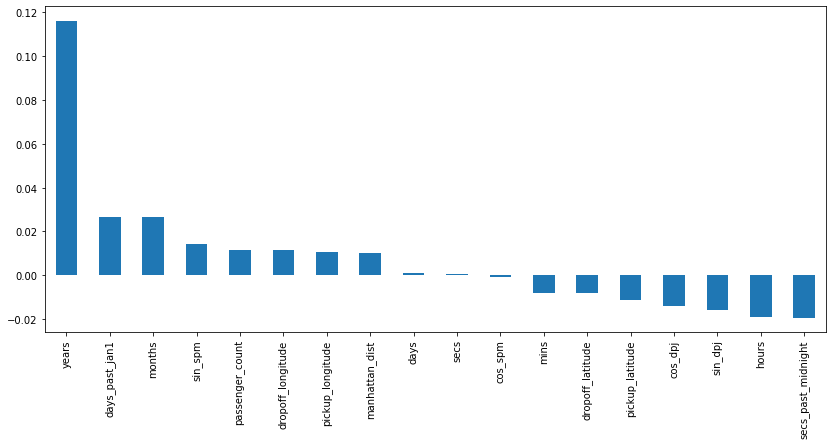

In [32]:
corr_graph = temp_chunk.corr()["fare_amount"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_graph.drop("fare_amount").plot.bar()
plt.show()

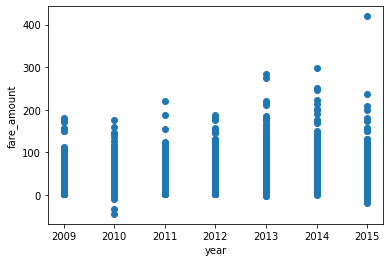

<Figure size 432x288 with 0 Axes>

In [31]:
plt.scatter(temp_chunk["years"],temp_chunk["fare_amount"])
plt.xlabel("year")
plt.ylabel("fare_amount")
plt.show()
plt.savefig("year_scatter")

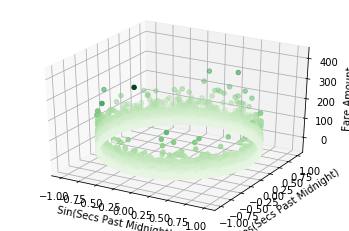

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
# zline = temp_chunk['fare_amount']
# xline = temp_chunk['sin_spm']
# yline = temp_chunk['cos_spm']
# ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = temp_chunk['fare_amount']
xdata = temp_chunk['sin_spm']
ydata = temp_chunk['cos_spm']
ax.set_xlabel("Sin(Secs Past Midnight)")
ax.set_ylabel("Cos(Secs Past Midnight)")
ax.set_zlabel("Fare Amount")
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
plt.savefig("sin_cos_spm_vs_fare")

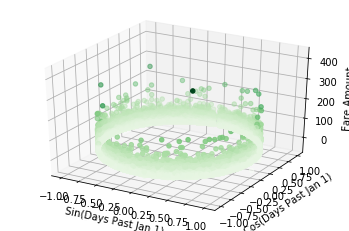

In [29]:
fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
# zline = temp_chunk['fare_amount']
# xline = temp_chunk['sin_spm']
# yline = temp_chunk['cos_spm']
# ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = temp_chunk['fare_amount']
xdata = temp_chunk['sin_dpj']
ydata = temp_chunk['cos_dpj']
ax.set_xlabel("Sin(Days Past Jan 1)")
ax.set_ylabel("Cos(Days Past Jan 1)")
ax.set_zlabel("Fare Amount")
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
plt.savefig("sin_cos_dpj_vs_fare")

# Detecting Outliers

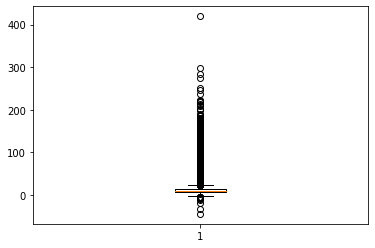

In [6]:
plt.boxplot(chunks[0].fare_amount)
plt.savefig("fare_amount_boxplot")

In [ ]:
chunks[0].to_csv('preprocessed.csv')
chunk1 = pd.read_csv('preprocessed.csv')
chunks.append(chunk1)
chunks[1].head()
chunks[0].describe()

In [ ]:
# indices = detect_outlier(chunks[1]['fare_amount'])
# for i in indices:
#     chunks[1] = chunks[1].drop([i])
#     print(i)

In [ ]:
chunks[1].to_csv('preprocessed1.csv')
chunks.append(pd.read_csv('preprocessed1.csv'))

# Restricting coordinates to NYC

All coordinates outside NYC are directly dropped

# Removing all rows with null values

In [ ]:
# type(chunks[0])
# print(chunks[0].isnull().sum())
# chunks[0].dropna(inplace = True)
# print(chunks[0].isnull().sum())
# chunks[0]['pickup_datetime'][0]
# chunks[0].describe()
# type(chunks[0]['dropoff_longitude'][161652])

# Splitting pickup date time 

# Generating secs after midnight and days past jan 1st

In [ ]:
# chunks[0] = chunks[0].drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
chunks[1].head()

In [ ]:
# chunks[0]['manhattan_dist'] = abs(chunks[0]['pickup_latitude']-chunks[0]['dropoff_latitude']) + abs(chunks[0]['pickup_longitude']-chunks[0]['dropoff_longitude'])

In [ ]:
chunks[0].head()

In [ ]:
# features = chunks[0].drop(['fare_amount','key','pickup_datetime', 'years', 'months', 'days', 'hours', 'mins', 'secs', 'secs_past_midnight', 'days_past_jan1'], axis = 1)
# target = chunks[0]['fare_amount']
# features = StandardScaler().fit_transform(features)

# pca = PCA(n_components=6)
# principalComponents = pca.fit_transform(features)
# principalDf = pd.DataFrame(data = principalComponents, columns = ['PrincipalC1', 'PrincipalC2', 'PrincipalC3','PrincipalC4', 'PrincipalC5', 'PrincipalC6'])
# finalDf = pd.concat([principalDf, target], axis=1)
# finalDf.head()
# chunks[0].head()

# Generating X and y

# Test train split & Linear Regression & RMSE

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# print(X1_train.shape)
# print(y1_train.shape)
# print(X1_test.shape)
# print(y1_test.shape)

# Applying Linear Regression

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

In [ ]:
# linreg1 = LinearRegression()
# linreg1.fit(X1_train, y1_train)

## Predicting outputs

In [ ]:
y_pred = linreg.predict(X_test)
# y1_pred = linreg1.predict(X1_test)

## Generating RMSE

In [ ]:
print("Without PCA: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("With PCA: ", np.sqrt(metrics.mean_squared_error(y1_test, y1_pred)))